In [1]:
import sys

sys.path.append("../..")
import numpy as np
import tensorflow as tf
from Bio import SeqIO

import tensortree

2025-10-10 13:41:26.998595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760096487.015804 3421354 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760096487.021048 3421354 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760096487.034916 3421354 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760096487.034938 3421354 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760096487.034939 3421354 computation_placer.cc:177] computation placer alr

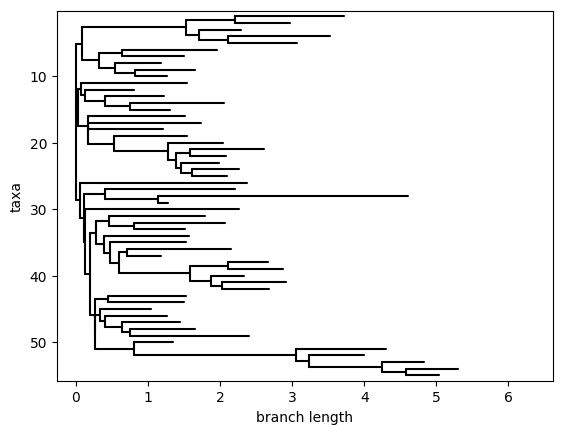

In [2]:
tree_file = "../data/PF00028.fasta.raxml.bestTree"
tree_handler = tensortree.TreeHandler.read(tree_file)
tree_handler.draw(no_labels=True)

In [3]:
msa_file = "../data/PF00028_gen.fa"
# sequences generated with above tree
!head {msa_file}

>CADH5_HUMAN/263-364
DIPSA------------GNVFKSA----GRNTGP----A----------GIAS--AP-----GG----------------LRKEPV-L--V-VLQA--RIT-LLSSLL-SE---VAQLYE-DGWAA-KRDVSD--T--LY----L--DV---ELVGSVLKEKK----VFAIGMPF----LLPVLK--------------LQA------DG--QVIYNGT-R-R--------DHLSAC-----------CYFKGG---V----EGLK-CGALPK--SGKTTY-----GVH--VSEFLYRHTNFC--LV-KSDYLLESNSRDIWGI-----------NYVLNGN--IAVNGEDF--WENKILKAYEEPEN----LVTNEGMET---M-RKYAHR-EDEAED---------I-GASFMLLEE-CPK-------------------------------GAQ---FRQ-----LFKTTIAIARA--TSAGAV---IDMFLPP-V--P------IS--VNRHKKAFLQKIPNCT-GL-----------VYDKADNVNNTTFPSYEGD-I---GREFA---VTAD----R-------NASSR-G--H-WWMA------LENKH---EI--LTDKAQ---C--D----RGGH-E---S------GRHLF---IPKPTWRT--------------AINLAVGGYL--LKDR-ES--R-AGDHMR------HEP-FGSNLTP---SA-------------IGV--YQRAK--YMGDVLQTVKWLLKNVRS-----PR--IDHELHN---------DQT--R-----GTIDGPTV--HALNGSGRV-H---L----------QDP-DKQWPVSAPGL----------AISE-----------RG--SYEHSVFIAIDEFLGRYPDVMGHFPL----DKSPL--II--------------------------------S--G-------H-

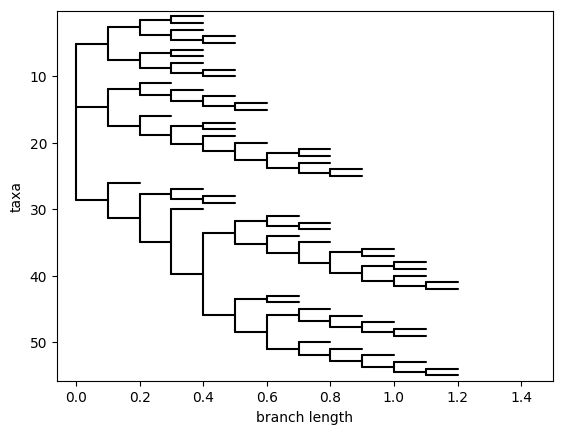

In [4]:
# make a tree with the same topology but with uniform branch lengths
initial_branch_length = 0.1
unit_tree_handler = tensortree.TreeHandler.copy(tree_handler)
unit_tree_handler.set_branch_lengths(
    np.ones_like(tree_handler.branch_lengths) * initial_branch_length
)
unit_tree_handler.draw(no_labels=True)

In [5]:
# parse fasta
import tensortree.model

alphabet = "ARNDCQEGHILKMFPSTWYV-"

leaf_names = []
seqs = []
for record in SeqIO.parse(msa_file, "fasta"):
    leaf_names.append(record.id)
    seqs.append(str(record.seq))

one_hot_leaves = tensortree.util.encode_one_hot(seqs, alphabet=alphabet)

# only learn on dense columns
sparse_columns = np.mean(one_hot_leaves[..., -1], axis=0) > 0.8
one_hot_leaves = one_hot_leaves[:,~sparse_columns]
one_hot_leaves = np.reshape(
    one_hot_leaves, 
    (one_hot_leaves.shape[0], 
     1,
     -1,
     one_hot_leaves.shape[-1])
)

#replace gaps with ones
one_hot_leaves[one_hot_leaves[..., -1] == 1] = 1
one_hot_leaves = one_hot_leaves[..., :-1] # remove gap dimension

one_hot_leaves.shape

(55, 1, 1990, 20)

In [6]:
conservation = np.max(np.mean(one_hot_leaves, axis=0), axis=-1)
np.argwhere(conservation[0] > 0.9).flatten()

array([], dtype=int64)

In [7]:
print("MSA depth:", len(seqs))
print("MSA width:", len(seqs[0]))
print("Tree height:", unit_tree_handler.height)
print("Tree nodes:", unit_tree_handler.num_nodes)

MSA depth: 55
MSA width: 4054
Tree height: 12
Tree nodes: 108


In [8]:
num_models = 1

# add length dimension
branch_lengths = unit_tree_handler.branch_lengths[..., np.newaxis].astype(np.float32)
branch_lengths.shape

(107, 1, 1)

In [9]:
tensortree.set_backend("tensorflow")

In [10]:
exchangeability_matrix, _ = tensortree.substitution_models.jukes_cantor(
    d = len(alphabet)-1
)
# add node and length dimensions
exchangeability_matrix = exchangeability_matrix[np.newaxis, :, np.newaxis,...] 

In [11]:
import tensortree.util


class LikelihoodGivenTreeModel(tf.keras.Model):
    """Optimizes the parameters (but not the topology) of a tree."""

    def __init__(
        self,
        tree_handler : tensortree.TreeHandler,
        exchangeability_matrix : np.ndarray,
        branch_lengths : np.ndarray,
        equilibrium_frequencies : np.ndarray,
        train_rate_matrix : bool = False,
        train_branch_lengths : bool = True,
        train_equilibrium_frequencies : bool = False,
        name: str = "LikelihoodGivenTreeModel",
        **kwargs
    ):
        super().__init__(name=name, **kwargs)
        self.branch_lengths = branch_lengths.astype(np.float32)
        self.branch_lengths_init = tensortree.backend.inverse_softplus(
            self.branch_lengths
        ).numpy()
        self.exchangeability_matrix = exchangeability_matrix.astype(np.float32)
        self.exchangeability_matrix_init = (
            tensortree.backend.inverse_softplus(
                self.exchangeability_matrix
            ).numpy()
        )
        self.equilibrium_frequencies = equilibrium_frequencies.astype(np.float32)
        self.equilibrium_frequencies_init = tf.math.log(
                self.equilibrium_frequencies
        ).numpy()
        self.tree_handler = tree_handler
        self.train_rate_matrix = train_rate_matrix
        self.train_branch_lengths = train_branch_lengths
        self.train_equilibrium_frequencies = train_equilibrium_frequencies


    def build(self, input_shape=None):
        # [num_leaves, num_models, seq_length]
        self.branch_lengths_kernel = self.add_weight(
            shape=self.branch_lengths.shape,
            initializer=tf.constant_initializer(self.branch_lengths_init),
            trainable=self.train_branch_lengths,
            name="branch_lengths_kernel",
        )
        # [num_leaves, num_models, seq_length, d, d]
        self.exchangeability_matrix_kernel = self.add_weight(
            shape=self.exchangeability_matrix.shape,
            initializer=tf.constant_initializer(self.exchangeability_matrix_init),
            trainable=self.train_rate_matrix,
            name="exchangeability_matrix_kernel",
        )
        # [num_models, d]
        self.equilibrium_frequencies_kernel = self.add_weight(
            shape=self.equilibrium_frequencies.shape,
            initializer=tf.constant_initializer(self.equilibrium_frequencies_init),
            trainable=self.train_equilibrium_frequencies,
            name="equilibrium_frequencies_kernel",
        )
        self.built = True


    def make_branch_lengths(self):
        return tensortree.backend.make_branch_lengths(
            self.branch_lengths_kernel
        )
    

    def make_equilibrium_frequencies(self):
        return tensortree.backend.make_equilibrium(
            self.equilibrium_frequencies_kernel
        )
    

    def make_exchangeability_matrix(self):
        return tensortree.backend.make_symmetric_pos_semidefinite(
            self.exchangeability_matrix_kernel
        )
    

    def make_rate_matrix(self):
        return tensortree.backend.make_rate_matrix(
            self.make_exchangeability_matrix(),
            self.make_equilibrium_frequencies(),
        )


    def loglik(self, inputs):
        # inputs: [num_leaves, num_models, seq_length, num_features]
        # outputs: [num_models, seq_length]
        transition_probs = tensortree.backend.make_transition_probs(
            self.make_rate_matrix(),
            self.make_branch_lengths(),
        )
        return tensortree.model.loglik(
            inputs,
            self.tree_handler,
            transition_probs,
            self.equilibrium_frequencies_kernel,
            leaf_names=leaf_names
        )


    def call(self, inputs):
        # inputs: [num_leaves, num_models, seq_length, num_features]
        # outputs: [num_models, seq_length]
        return self.loglik(inputs)



    def compute_loss(self, x, y, y_pred, sample_weight):
        # average over models and sum over length
        y_pred = tf.reduce_mean(y_pred, axis=0)
        y_pred = tf.reduce_sum(y_pred)
        return -y_pred

In [12]:
equilibrium_frequencies = np.ones(
    (num_models, one_hot_leaves.shape[2], len(alphabet)-1)) / len(alphabet
)
model = LikelihoodGivenTreeModel(
    unit_tree_handler,
    exchangeability_matrix=exchangeability_matrix,
    branch_lengths=branch_lengths,
    equilibrium_frequencies=equilibrium_frequencies,
    train_rate_matrix=True,
    train_branch_lengths=True,
    train_equilibrium_frequencies=True,
)

I0000 00:00:1760096489.935961 3421354 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21872 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [13]:
model.build()

Text(0.5, 1.0, 'Initial rate matrix')

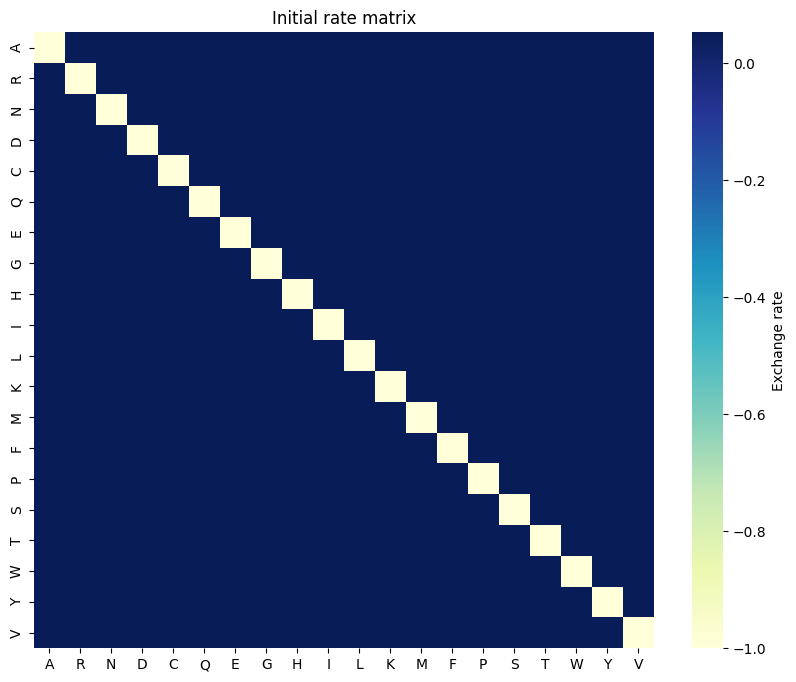

In [14]:
initial_rate_matrix = model.make_rate_matrix()[0,0,0]
# make a heatmap from above 20x20 matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(
    initial_rate_matrix,
    xticklabels=alphabet[:-1],
    yticklabels=alphabet[:-1],
    cmap="YlGnBu",
    cbar_kws={"label": "Exchange rate"},
).set_title("Initial rate matrix")

In [15]:
model(one_hot_leaves)

I0000 00:00:1760096492.413421 3421354 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x5e54dba4c2f0


<tf.Tensor: shape=(1, 1990), dtype=float32, numpy=
array([[-1088.8145 , -1053.327  , -1078.3695 , ...,  -103.92216,
         -160.5581 , -1074.5308 ]], dtype=float32)>

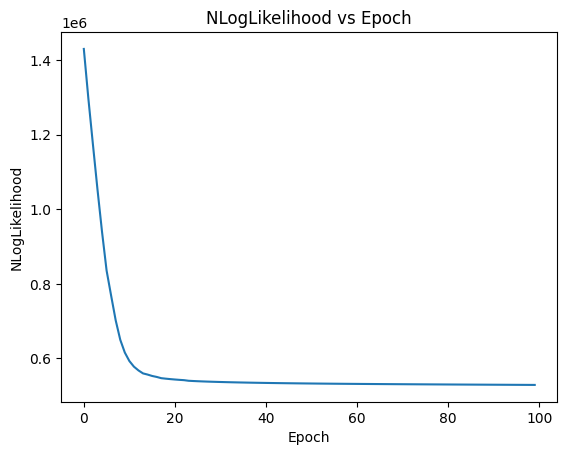

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-1)
# disable jit_compile otherwise the matrix exponential gradient will fail
model.compile(optimizer, jit_compile=False)
model.fit(
    one_hot_leaves,
    batch_size=one_hot_leaves.shape[0],
    epochs=100,
    verbose=0,
    shuffle=False
)
# plot the loss
import matplotlib.pyplot as plt
plt.plot(model.history.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("NLogLikelihood")
plt.title("NLogLikelihood vs Epoch")
plt.show()

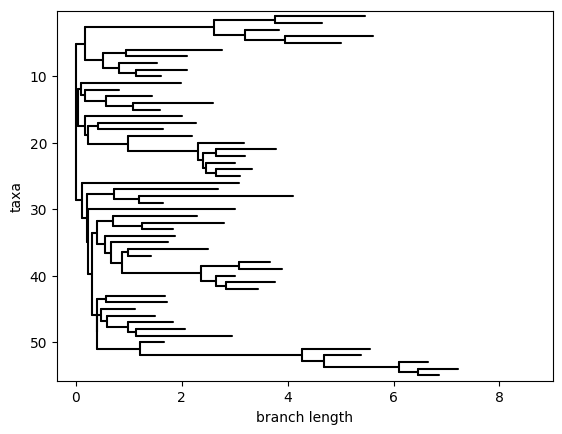

In [17]:
optimized_tree_handler = tensortree.TreeHandler.copy(tree_handler)
optimized_tree_handler.set_branch_lengths(model.make_branch_lengths()[...,-1].numpy())
optimized_tree_handler.draw(no_labels=True)

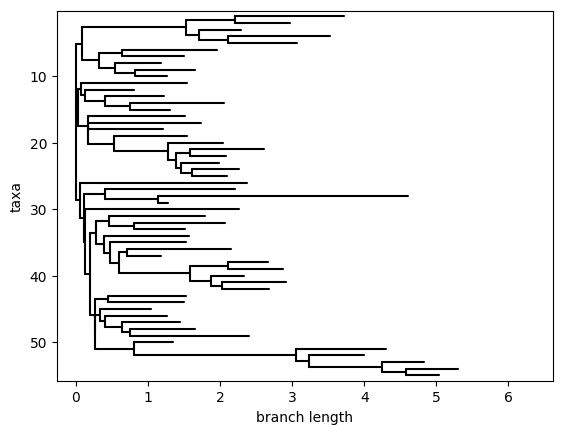

In [18]:
tree_handler.draw(no_labels=True)

Text(0.5, 1.0, 'Learned rate matrix')

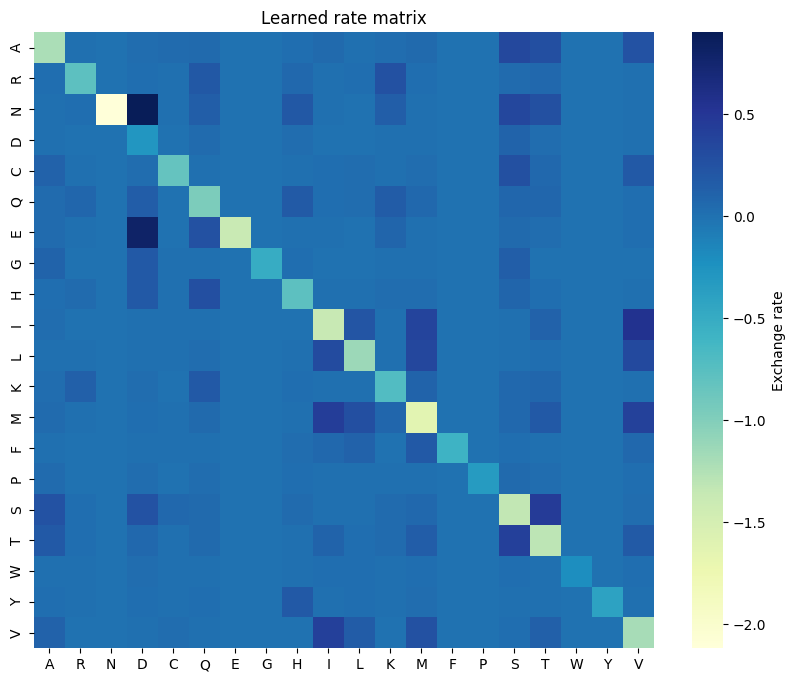

In [19]:
learned_rate_matrix = model.make_rate_matrix()[0,0,0]
# make a heatmap from above 20x20 matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(
    learned_rate_matrix,
    xticklabels=alphabet[:-1],
    yticklabels=alphabet[:-1],
    cmap="YlGnBu",
    cbar_kws={"label": "Exchange rate"},
).set_title("Learned rate matrix")

Text(0.5, 1.0, 'LG rate matrix')

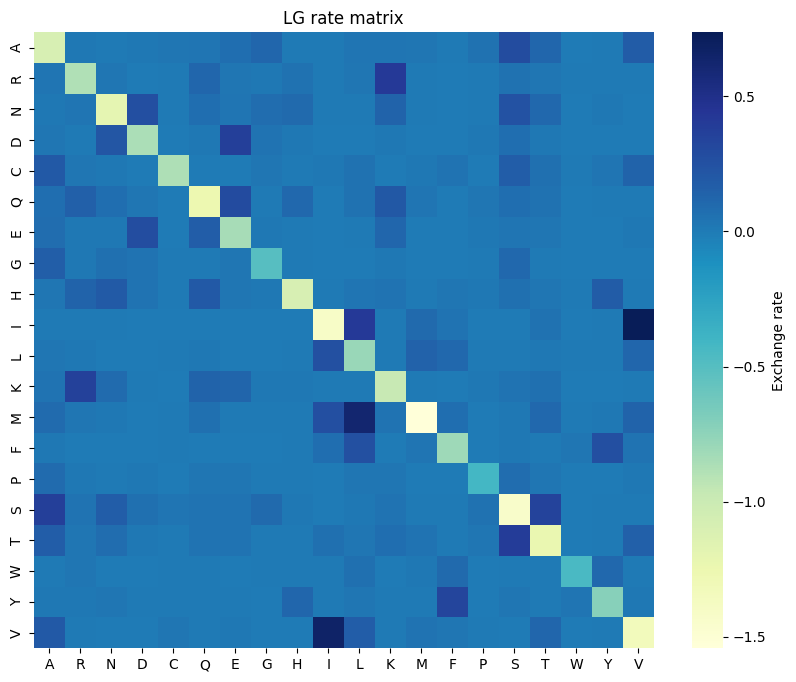

In [20]:
R, pi = tensortree.substitution_models.LG()
LG_rate_matrix = tensortree.backend.make_rate_matrix(R, pi)
plt.figure(figsize=(10, 8))
sns.heatmap(
    LG_rate_matrix,
    xticklabels=alphabet[:-1],
    yticklabels=alphabet[:-1],
    cmap="YlGnBu",
    cbar_kws={"label": "Exchange rate"},
).set_title("LG rate matrix")